# Handwritten Digit Classifier (MNIST) + INT8 Quantization (TFLite)

This notebook:
1. Loads MNIST and prepares the data.  
2. Builds and trains a simple CNN.  
3. Converts the model to **TensorFlow Lite INT8** (weights + activations).  
4. Tests the quantized model and shows sample predictions.

Ready to run in Google Colab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## 1. Load and preprocess MNIST

MNIST is a classic dataset of 70k grayscale 28×28 images of digits 0–9.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In [3]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

print("After preprocessing:", x_train.shape, x_test.shape)

After preprocessing: (60000, 28, 28, 1) (10000, 28, 28, 1)


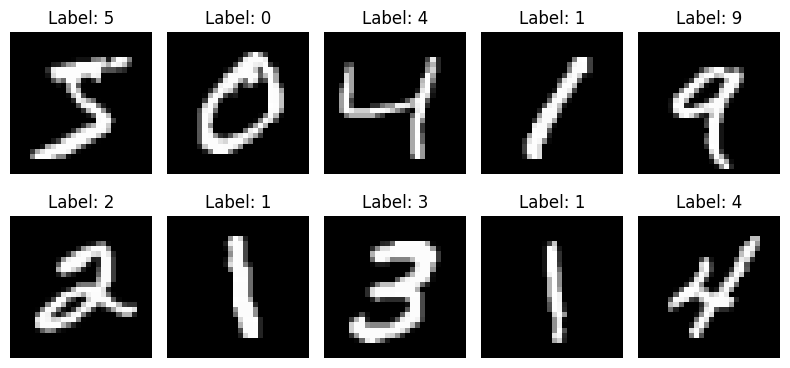

In [4]:
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 2. Define the CNN model

A simple but effective MNIST architecture:
- 2× (Conv + MaxPool)
- Dense 128
- Dropout for regularization

In [5]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax")
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## 3. Train the model

In [7]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8263 - loss: 0.5797 - val_accuracy: 0.9823 - val_loss: 0.0633
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9758 - loss: 0.0784 - val_accuracy: 0.9863 - val_loss: 0.0448
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9832 - loss: 0.0555 - val_accuracy: 0.9908 - val_loss: 0.0346
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9880 - loss: 0.0382 - val_accuracy: 0.9892 - val_loss: 0.0352
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9892 - loss: 0.0345 - val_accuracy: 0.9917 - val_loss: 0.0323


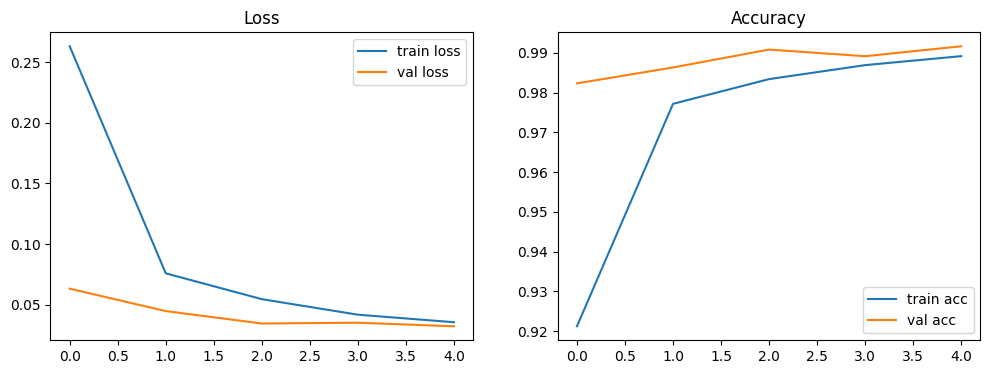

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy")

plt.show()

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy (float32):", test_acc)

Test accuracy (float32): 0.9907000064849854


## 4. Post‑training INT8 quantization (TensorFlow Lite)

We do full INT8 quantization:
- use a representative dataset to calibrate activation ranges
- force INT8 ops
- INT8 input/output (good for embedded/edge devices)

In [10]:
def representative_data_gen():
    for i in range(500):
        img = x_train[i]
        img = np.expand_dims(img, axis=0)
        img = img.astype("float32")
        yield [img]

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

tflite_model_path = "mnist_cnn_int8.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("Saved quantized model to:", tflite_model_path)
print("INT8 model size:", len(tflite_model)/1024, "KB")

Saved artifact at '/tmp/tmps1xln3fs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139923884799760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923884801680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923884801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923884801488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923839648592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923839649360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923884800144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139923839647824: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved quantized model to: mnist_cnn_int8.tflite
INT8 model size: 229.7265625 KB


## 5. Test the INT8 TFLite model

TFLite uses INT8 tensors, so we:
1. read input/output scale and zero point,
2. quantize input images,
3. run the interpreter and dequantize outputs.

In [12]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 17, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [13]:
def tflite_predict(img):
    """
    img: (28, 28, 1) float32 in [0, 1]
    returns: (pred_label, probs_float)
    """
    input_index = input_details[0]["index"]
    in_scale, in_zero = input_details[0]["quantization"]

    img_q = img / in_scale + in_zero
    img_q = np.round(img_q).astype(np.int8)
    img_q = np.expand_dims(img_q, axis=0)

    interpreter.set_tensor(input_index, img_q)
    interpreter.invoke()

    output_index = output_details[0]["index"]
    output_q = interpreter.get_tensor(output_index)

    out_scale, out_zero = output_details[0]["quantization"]
    if out_scale > 0:
        probs = (output_q.astype(np.float32) - out_zero) * out_scale
    else:
        probs = output_q.astype(np.float32)

    probs = probs[0]
    pred_label = np.argmax(probs)
    return pred_label, probs

In [14]:
correct = 0
N = 1000

for i in range(N):
    img = x_test[i]
    true_label = y_test[i]
    pred_label, _ = tflite_predict(img)
    if pred_label == true_label:
        correct += 1

tflite_acc = correct / N
print(f"Approx. TFLite INT8 accuracy on {N} samples: {tflite_acc:.4f}")

Approx. TFLite INT8 accuracy on 1000 samples: 0.9890


## 6. Visualize a few INT8 predictions

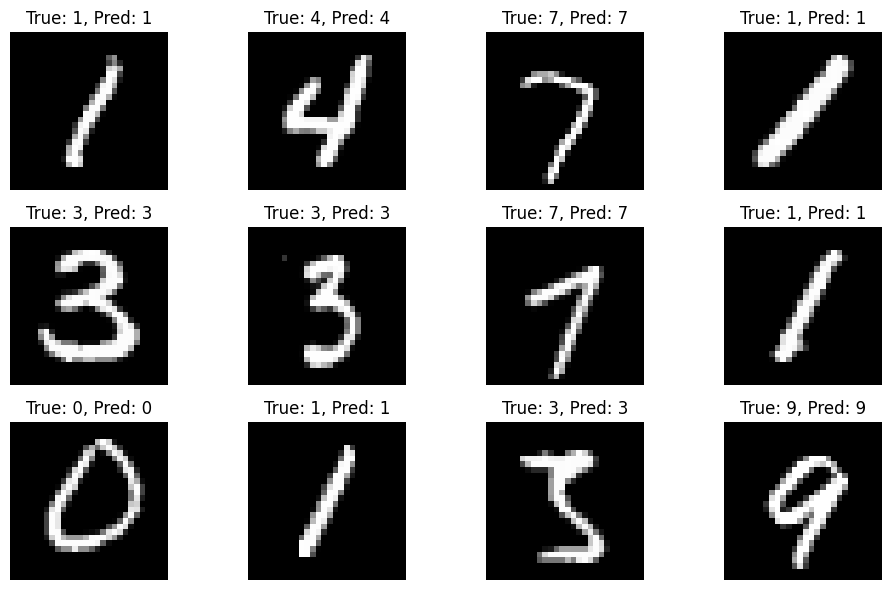

In [15]:
plt.figure(figsize=(10, 6))
for i in range(12):
    idx = np.random.randint(0, len(x_test))
    img = x_test[idx]
    true_label = y_test[idx]
    pred_label, _ = tflite_predict(img)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()